# Figure 1: Adhesome genes/loci are close in HiC

In [1]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
import pyvis as pv
from pyvis.network import Network
# Custom libraries
import utils as lu
import correlation_clustering as cc
# Reload modules in case of modifications
reload(lu)
reload(cc)

<module 'correlation_clustering' from '/home/louiscam/projects/gpcr/code/figures4/correlation_clustering.py'>

In [2]:
# Specify all directories
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# RNAseq directory
dir_rna = '/home/louiscam/projects/gpcr/data/bulk_rnaseq/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/epigenome_data/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_epigenome_data_dir/'
# Directpry of TF target data
dir_htftarget = '/home/louiscam/projects/gpcr/data/tf_data/hTFtarget/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [3]:
# Relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load gene data

In [4]:
# Gene location in hg19
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = lu.get_all_gene_locations(gene_locations_filename, gene_id_filename)
df_loc['geneLength'] = df_loc['chromEnd']-df_loc['chromStart']
genes_df = df_loc[['geneSymbol', 'geneLength']].set_index('geneSymbol')

In [5]:
# Active/inactive loci
all_active_loci = pickle.load(open(saving_dir+'all_active_loci.pkl', 'rb'))
all_inactive_loci = pickle.load(open(saving_dir+'all_inactive_loci.pkl', 'rb'))
# Active/inactive genes
active_genes = pickle.load(open(saving_dir+'active_genes.pkl','rb'))
inactive_genes = pickle.load(open(saving_dir+'inactive_genes.pkl','rb'))

In [6]:
# Adhesome genes
active_adhesome_loci = pickle.load(open(saving_dir+'active_adhesome_loci.pkl', 'rb'))
inactive_adhesome_loci = pickle.load(open(saving_dir+'inactive_adhesome_loci.pkl', 'rb'))
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes.pkl','rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes.pkl','rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))

In [7]:
# TF genes
active_lung_adhesome_tf_genes = pickle.load(open(saving_dir+'active_lung_adhesome_tf_genes.pkl','rb'))


In [8]:
# Mapping gene to chromosome
gene2chrom = pickle.load(open(saving_dir+'gene2chrom.pkl', 'rb'))

# Breakdown of TFs

In [9]:
# Load data
htargettf_df = pd.read_csv(dir_htftarget+'hTFtarget.txt', sep='\t', header=0)
htargettf_df['adhesome target'] = htargettf_df['target'].isin(active_adhesome_genes)
htargettf_df['lung'] = htargettf_df['tissue'].str.contains('lung')
lung_tfs = htargettf_df[htargettf_df['lung']==True]['TF'].unique()
adhesome_lung_tfs = htargettf_df[(htargettf_df['lung']==True) & (htargettf_df['adhesome target']==True)]['TF'].unique()
print('Number of unique TFs = '+str(len(np.unique(htargettf_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_df)))

Number of unique TFs = 495
Number of unique targets = 38183
Number of TF-target links = 1342129


In [10]:
# Select only lung TF-target links
htargettf_lung_df = htargettf_df[htargettf_df['lung']==True]
print('Number of unique TFs = '+str(len(np.unique(htargettf_lung_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_lung_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_lung_df)))

Number of unique TFs = 76
Number of unique targets = 32734
Number of TF-target links = 253173


In [11]:
# Select only lung TF-target links with adhesome targets
htargettf_lung_adh_df = htargettf_df[(htargettf_df['lung']==True) & (htargettf_df['adhesome target']==True)]
print('Number of unique TFs = '+str(len(np.unique(htargettf_lung_adh_df['TF']))))
print('Number of unique targets = '+str(len(np.unique(htargettf_lung_adh_df['target']))))
print('Number of TF-target links = '+str(len(htargettf_lung_adh_df)))

Number of unique TFs = 58
Number of unique targets = 195
Number of TF-target links = 2924


In [12]:
# Annotation
cat = []
cat_id = []
for i in tqdm(range(htargettf_df.shape[0])):
    if htargettf_df['lung'].iloc[i]==False:
        cat.append('other TFs')
        cat_id.append(3)
    elif htargettf_df['adhesome target'].iloc[i]==False:
        cat.append('other lung TFs')
        cat_id.append(2)
    else:
        cat.append('lung adhesome TFs')
        cat_id.append(1)
htargettf_df['category'] = cat
htargettf_df['category_id'] = cat_id

100%|██████████| 1342129/1342129 [00:14<00:00, 94698.29it/s] 


In [13]:
htargettf_df.sort_values('category_id').drop_duplicates(subset=['TF'], keep='first').groupby('category').nunique()[['TF']].loc[['lung adhesome TFs','other lung TFs','other TFs']]


,TF
category,
lung adhesome TFs,58
other lung TFs,18
other TFs,419


<Figure size 432x288 with 0 Axes>

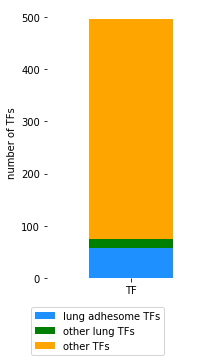

In [14]:
# Barplot
plt.figure()
htargettf_df.sort_values('category_id').drop_duplicates(subset=['TF'], keep='first').groupby('category').nunique()[['TF']].loc[['lung adhesome TFs','other lung TFs','other TFs']].T.plot.bar(stacked=True, color=['dodgerblue','green','orange'], rot=0, figsize=(3,5))
sns.despine(left=True, bottom=True, right=True)
plt.ylabel('number of TFs')
plt.legend(loc='lower center', bbox_to_anchor=(0.3,-0.3))
plt.show()

# Expression of TFs targeting adhesome genes

In [15]:
# Load clustering
df_clusters = pickle.load(open(saving_dir+'active_inactive_genes.pkl', 'rb'))[['RNAseq','type']]
all_tfs = htargettf_df['TF'].unique()
tf_clusters = df_clusters.loc[df_clusters.index.isin(all_tfs)]
tf_clusters['adhesome_lung_tfs'] = tf_clusters.index.isin(adhesome_lung_tfs)
nonadhesome_lung_tfs = np.array(list(set(lung_tfs)-set(adhesome_lung_tfs)))
tf_clusters['nonadhesome_lung_tfs'] = tf_clusters.index.isin(nonadhesome_lung_tfs)
nonadhesome_nonlung_tfs = np.array(list(set(all_tfs)-set(adhesome_lung_tfs)-set(nonadhesome_lung_tfs)))
tf_clusters['nonadhesome_nonlung_tfs'] = tf_clusters.index.isin(nonadhesome_nonlung_tfs)
tf_clusters = tf_clusters[tf_clusters['type']=='active genes']

In [17]:
tf_clusters

,RNAseq,type,adhesome_lung_tfs,nonadhesome_lung_tfs,nonadhesome_nonlung_tfs
AEBP2,0.365451,active genes,False,False,True
AFF4,0.931982,active genes,False,False,True
AHR,0.460137,active genes,False,False,True
ARID3A,0.632756,active genes,False,False,True
ARNT,0.840369,active genes,False,False,True
...,...,...,...,...,...
ZNF395,0.695185,active genes,False,False,True
ZNF706,0.760896,active genes,False,False,True
ZNF76,0.490077,active genes,False,False,True
ZNF83,0.704306,active genes,False,False,True


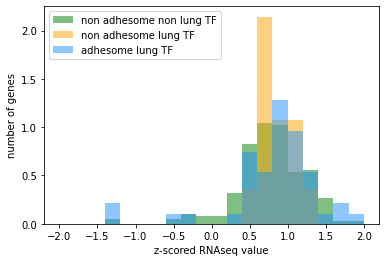

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=-0.325863285852781, pvalue=0.7445277944485396)


In [16]:
# Plot expression of active TFs
plt.figure()
plt.hist(tf_clusters[tf_clusters['nonadhesome_nonlung_tfs']==True]['RNAseq'].values, bins=np.arange(-2,2.2,0.2),
         density=True,
         color='green', alpha=0.5, label='non adhesome non lung TF')
plt.hist(tf_clusters[tf_clusters['nonadhesome_lung_tfs']==True]['RNAseq'].values, bins=np.arange(-2,2.2,0.2),
         density=True,
         color='orange', alpha=0.5, label='non adhesome lung TF')
plt.hist(tf_clusters[tf_clusters['adhesome_lung_tfs']==True]['RNAseq'].values, bins=np.arange(-2,2.2,0.2),
         density=True,
         color='dodgerblue', alpha=0.5, label='adhesome lung TF')
plt.xlabel('z-scored RNAseq value')
plt.ylabel('number of genes')
plt.legend(loc='upper left')
plt.show()
print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(tf_clusters[tf_clusters['nonadhesome_lung_tfs']==True]['RNAseq'].values,
                  tf_clusters[tf_clusters['adhesome_lung_tfs']==True]['RNAseq'].values))

# TFs targeting adhesome genes are correlated in expression with adhesome genes

In [208]:
# Create regulatory edge list
df_all_norm = pd.read_csv(saving_dir+'features_matrix_all_genes_norm.csv', header=0, index_col=0)
np.random.seed(13)
random_tfs = np.random.choice(np.array(list(set(all_tfs)-set(adhesome_lung_tfs))), len(active_lung_adhesome_tf_genes))
random_tfs = np.array(list(set(random_tfs).intersection(set(df_all_norm.columns))))
selected_genes = np.array(list(set(active_adhesome_genes).union(set(active_lung_adhesome_tf_genes)).union(set(random_tfs))))
df_reg_adhesome = df_all_norm.loc[:, selected_genes]

In [210]:
# Create regulatory correlation matrix
S_reg_adhesome = df_reg_adhesome.corr(method='pearson').values
S_reg_adhesome_df = pd.DataFrame(S_reg_adhesome, index=selected_genes, columns=selected_genes)

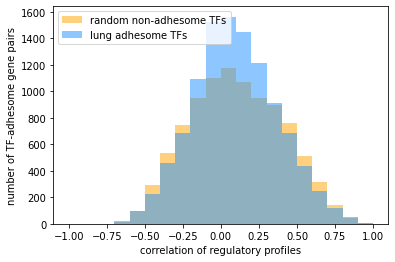

In [214]:
# Compare regulatory correlation distributions
plt.figure()
plt.hist(S_reg_adhesome_df.loc[random_tfs,active_adhesome_genes].values.flatten(), bins=np.arange(-1,1.1,0.1),
         color='orange', alpha=0.5, label='random non-adhesome TFs')
plt.hist(S_reg_adhesome_df.loc[active_lung_adhesome_tf_genes,active_adhesome_genes].values.flatten(), bins=np.arange(-1,1.1,0.1),
         color='dodgerblue', alpha=0.5, label='lung adhesome TFs')
plt.xlabel('correlation of regulatory profiles')
plt.ylabel('number of TF-adhesome gene pairs')
plt.legend(loc='upper left')
plt.show()

# Adhesome genes targeted by TFs

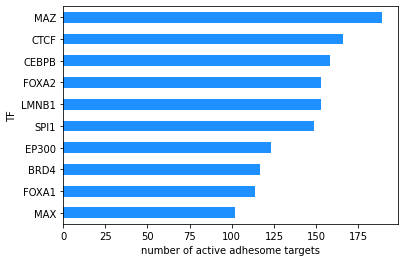

In [234]:
# Barplot of adhesome TFs
adhesome_lung_htargettf_df = htargettf_df[(htargettf_df['lung']==True) & (htargettf_df['adhesome target']==True)]
plt.figure()
adhesome_lung_htargettf_df.groupby(['TF']).nunique()['target'].sort_values(ascending=True)[-10:].plot.barh(color='dodgerblue')
plt.xlabel('number of active adhesome targets')
plt.show()

In [267]:
# Obtain proportion of genome targets and proportion of adhesome targets for each adhesome TF
adhesome_htargettf_df = htargettf_df[htargettf_df['TF'].isin(active_lung_adhesome_tf_genes)]
prop_genome_df = (adhesome_htargettf_df.groupby(['TF'])['target'].nunique()/df_all_norm.shape[1]).reset_index().set_index('TF')
prop_adhesome_df = (adhesome_htargettf_df.groupby(['TF'])['adhesome target'].sum()/len(active_adhesome_genes)).reset_index().set_index('TF')
tf_char_df = prop_genome_df.join(prop_adhesome_df, how='outer')
tf_char_df.columns=['prop_genome_targets', 'prop_adhesome_targets']

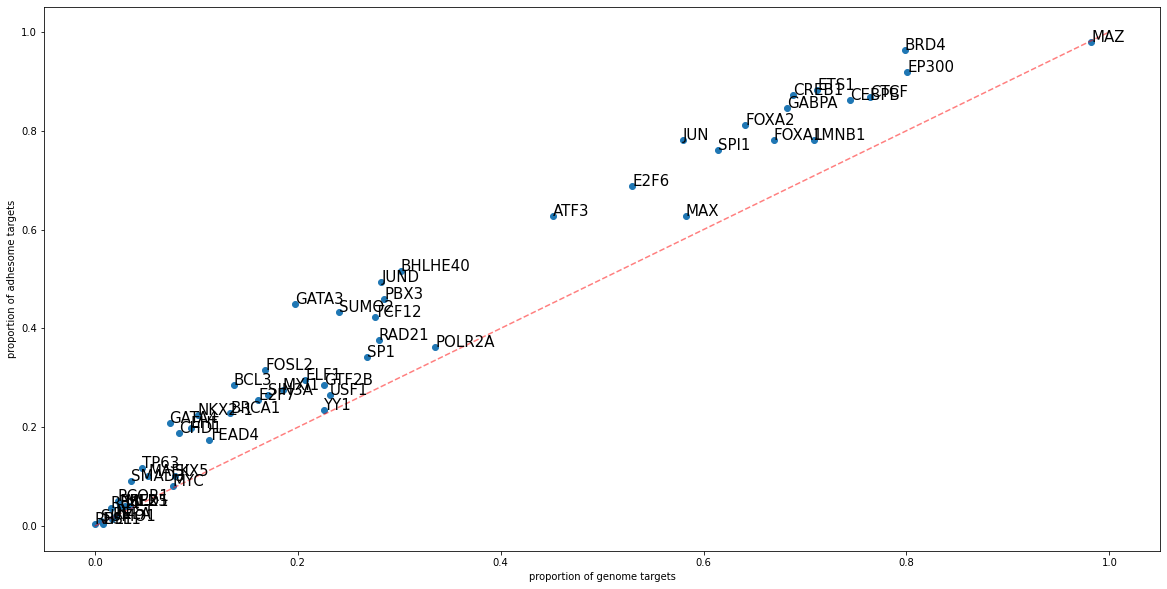

In [277]:
# Plot TFs on prop_genome_targets - prop_adhesome_targets space
fig, ax = plt.subplots(figsize=(20,10))
x = tf_char_df['prop_genome_targets']
y = tf_char_df['prop_adhesome_targets']
labels = tf_char_df.index.values
ax.scatter(x, y)
ax.plot((0,1),(0,1), color='red', linestyle='dashed', alpha=0.5)
for i in range(tf_char_df.shape[0]):
    ax.annotate(labels[i], (x[i], y[i]), size=15)
plt.xlabel('proportion of genome targets')
plt.ylabel('proportion of adhesome targets')
plt.show()